<a href="https://colab.research.google.com/github/ahmedabdelhameed/TensorFlow/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GAN implementation tested on MNIST dataset**

In [49]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Input, Dense, Conv2D, LeakyReLU, BatchNormalization, Dropout, Reshape, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse, BinaryCrossentropy
import matplotlib.pyplot as plt

In [50]:
#Downloading the dataset
(x_train_orig, y_train), (x_test_orig, y_test) = mnist.load_data()


x_train = x_train_orig.reshape(x_train_orig.shape[0], x_train_orig.shape[1], x_train_orig.shape[2], 1).astype('float32')
#x_test = np.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))

# x_train = x_train_orig.astype('float32') / 255.
# x_test = x_test_orig.astype('float32') / 255.

x_train = (x_train-127.5) / 127.5


In [51]:
x_train.shape

(60000, 28, 28, 1)

In [73]:
img_size = 28
num_channels = 1


EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [113]:
# Batch and shuffle the data
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# for element in train_dataset:
#   print(element.shape)

In [114]:
def define_discriminator():
  model = Sequential()
  model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(1))
  return model

In [115]:
# define model
discriminator = define_discriminator()
# summarize the model
discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)             

In [116]:
# Building the generator model
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

In [117]:
generator = make_generator_model()
generator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_9 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 7, 7, 128)       

In [118]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = BinaryCrossentropy(from_logits=True) #This includes sigmoid

In [119]:
#Define losses

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [120]:
#Define optimizers
discriminator_optimizer = Adam(1e-4)
generator_optimizer = Adam(1e-4)

In [130]:
@tf.function
def train_step(images):
  batch_size = tf.shape(images)[0]
  #print(batch_size)
  # random_noise = tf.random.normal(batch_size,100)  #fake noice images vectors of size 100
  random_noise= tf.random.normal([batch_size, noise_dim])
  #random_noise= tf.random.normal([BATCH_SIZE, noise_dim])
  #print(random_noise.dtype)
  #print("hi")

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(random_noise, training=True)
    #generated_labels = tf.zeros((batch_size, 1))
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images,  training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

  #print("generator loss:", np.mean(gen_loss))
  #print("discriminator loss: ", np.mean(disc_loss))

In [134]:
# Training
import time
from IPython import display

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for images in dataset:
      train_step(images)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [135]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

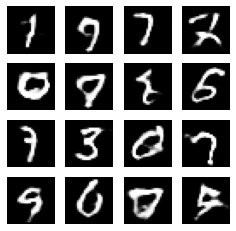

Time for epoch 85 is 6.557768821716309 sec


In [ ]:
train(train_dataset, EPOCHS)